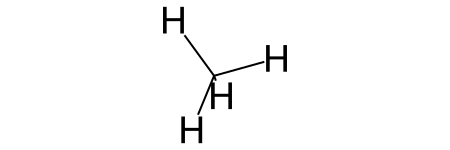

In [1]:
import subprocess

from rdkit import Chem

from molclub import xtb, conf

params = xtb.Parameters()

mol = Chem.MolFromSmiles('C')
mol = conf.etkdg_conf_gen(mol)
mol

In [2]:
xtb.job(
    mol,
    params=params,
    job_type='opt',
)

Output(cwd='/var/folders/n8/vbbw9ls578n4msgwm3tg7cr00000gn/T/tmp5rnqwvxw', energy_kcal=-2619.77447459938, energy_hartree=-4.174939401752, num_steps=0, dipole=Dipole(x='-0.000', y='-0.000', z='0.000', total='0.001'))

In [4]:
xtb.job(
    mol,
    params=params,
    job_type='sp',
    use_temp_dir=False,
    working_dir='./tmp'
)

Output(cwd='./tmp', energy_kcal=-2618.37172830372, energy_hartree=-4.172703949488, num_steps=0, dipole=Dipole(x='0.011', y='0.001', z='-0.005', total='0.031'))